# Project 1: Heart diseases

## Imports

In [132]:
import pandas as pd
from tabula import read_pdf
import matplotlib.pyplot as plt
import numpy as np
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

## Contents
- [0. Load data](#0.-Load-data)
- [1. Columns](#1.-Columns)
- [2. Clean Up](#2.-Clean-Up)

### Complete attribute documentation:
- 1 id: patient identification number
- 3 age: age in years
- 4 sex: sex (1 = male; 0 = female)
- 9 cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- 10 trestbps: resting blood pressure (in mm Hg on admission to the 
        hospital)
- 12 chol: serum cholestoral in mg/dl
- 16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
- 19 restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
            elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy
            by Estes' criteria
- 32 thalach: maximum heart rate achieved
- 38 exang: exercise induced angina (1 = yes; 0 = no)
- 40 oldpeak = ST depression induced by exercise relative to rest
- 41 slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- 44 ca: number of major vessels (0-3) colored by flourosopy
- 51 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
     
- predicted

## 0. Load data

In [2]:
df_H = pd.read_excel('datos\\Hungarian_Switzerland.xlsx', sheet_name=0)
df_S = pd.read_excel('datos\\Hungarian_Switzerland.xlsx', sheet_name=1)
df_Clev = pd.read_csv('datos\\processed.cleveland.data', header = None)
df_LB = read_pdf('datos\\LongBeachData.pdf', pages ='all')

## 1. Columns homogeneization

In [3]:
column_names = ['id','age', 'sex', 'cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','predicted']  
print(len(column_names))

15


In [4]:
new_column_name = 'id'
new_column_value = [f'Patient {i+1}' for i in range(len(df_Clev))]
df_Clev.insert(0, new_column_name, new_column_value)

In [5]:
df_LB_nohead = {}
for i, df in enumerate(df_LB[1:7]):
    header_row = [df.columns.tolist()]
    header_df = pd.DataFrame(header_row, columns=df.columns)
    df_with_header = pd.concat([header_df, df], ignore_index=True)
    df_LB_nohead[i] = df_with_header

In [6]:
df_S.columns = column_names
df_H.columns = column_names
df_Clev.columns = column_names
df_LB[0].columns = column_names
for _, df in df_LB_nohead.items():
    df.columns = column_names

We will concatenate later, it will be easier to clean data types having dataframes separated.



## 2. Clean Up

### Putting df's from different hospitals into a list and adding hospital index
We will add a column = 'hospital_id' in which Switzerland patients = 1, Hungarian = 2, Cleveland = 3 and Long Beach = 4 

In [7]:
dataframes = [df_S, df_H, df_Clev, df_LB[0]] # los guardo en una lista todos para poder iterar sobre los dataframes
dataframes.extend(list(df_LB_nohead.values()))

In [8]:
print (dataframes)

[              id  age  sex  cp trestbps  chol fbs restecg thalach exang  \
0      Patient 1   32    1   1       95     0   ?       0     127     0   
1      Patient 2   34    1   4      115     0   ?       ?     154     0   
2      Patient 3   35    1   4        ?     0   ?       0     130     1   
3      Patient 4   36    1   4      110     0   ?       0     125     1   
4      Patient 5   38    0   4      105     0   ?       0     166     0   
..           ...  ...  ...  ..      ...   ...  ..     ...     ...   ...   
118  Patient 119   70    1   4      115     0   0       1      92     1   
119  Patient 120   70    1   4      140     0   1       0     157     1   
120  Patient 121   72    1   3      160     0   ?       2     114     0   
121  Patient 122   73    0   3      160     0   0       1     121     0   
122  Patient 123   74    1   2      145     0   ?       1     123     0   

    oldpeak slope ca thal  predicted  
0        .7     1  ?    ?          1  
1        .2     1  ?

In [9]:
def convert_to_int_or_nan(value):
    '''
    Function to handle columns that should be ints or boolean but have decimals, (no sabemos porque, pasa en pocas filas), 
    to convert them to values that can be used later with .astype()
    '''
    try:
        # First, try to convert to float
        float_val = float(value)
        # If successful, check if it's an integer or float
        if float_val.is_integer():
            # It's an integer, return as is
            return int(float_val)
        else:
            returnee = np.nan
            return returnee
    except (TypeError, ValueError) as e:
        returnee = np.nan
        return returnee

En este loop aprovecho para hacer varias cosas: 
- Rehacer los indices de los pacientes
- Añadir la columna con el número del hospital de origen
- Homogeneizar los tipos de datos en cada columna (Repasálo para ver si está bien esto, y compara o preguntale al Agustí)

In [10]:
dataframes_clean_up = copy.deepcopy(dataframes) # copio la lista en una variable diferente para poder modificar la copia 
                                                # sin tocar el original. Así no hay que volver arriba cada vez que quieras recorrer

patients_counter = 0 # contador para asignar un id de paciente de 0 a len(dataframes_concatenados)

# LOOPING OVER ALL DATAFRAMES BEFORE CONCATENATING
for df_index, df in enumerate(dataframes_clean_up):
    
    # Rehacer los indices de pacientes
    for row_index, row in df.iterrows():
        
        patients_counter += 1 # cada fila sumamos 1 y lo usamos para rehacer los indices del dataset entero
                                # sino ahora mismo cada dataframe comienza por el Patient 1, 2, 3
        df['id'][row_index] = patients_counter # sustituimos lo que hay ahora por el numero
        
    # ADDING THE HOSPITAL INDEX
    if df_index<3:
        hospital_index = df_index+1
    else:
        hospital_index = 4 # to put index 4 for all the Long Beach df's
    new_column_name = 'hospital_id'
    new_column_value = [hospital_index for _ in range(len(df))]
    df.insert(14, new_column_name, new_column_value)

    print(df_index, row_index)
    
    ##################################################
    ## HOMOGENIZAR TIPOS DE DATOS PARA CADA COLUMNA ##
    ##################################################
    
    # REPLACE '?' with NaNs
    df.replace('?', pd.NA, inplace=True)
    
    # Convert to int 
    # Estos no dan problemas
    convert2_int_columns = ['age', 'sex']
    for col in convert2_int_columns:
        df[col] = df[col].astype(int)
    
    # Convert to float
    convert2_float_columns = ['cp', 'trestbps', 'chol', 'restecg', 'thalach','oldpeak','chol', 'slope']
    for col in convert2_float_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') # coerce fuerza a que convierta los errores en Nans
    
    # Convert to boolean
    convert2_boolean_columns = ['fbs','exang']
    for col in convert2_boolean_columns:
        for row_index, row_value in enumerate(df[col]):
            conv_value = convert_to_int_or_nan(row_value) # converts floats to Nans
            df[col][row_index] = conv_value # save element-wise
        
        df[col] = df[col].astype('boolean') # now that we dont have floats,  we can convert ints and Nans all to boolean
    
    # Convert problematic ints
    convert2_int_columns = ['ca', 'slope', 'predicted','thal']
    for col in convert2_int_columns:
        for row_index, row_value in enumerate(df[col]):
            conv_value = convert_to_int_or_nan(row_value) # converts floats to Nans
            df[col][row_index] = conv_value # save element-wise
        
        df[col] = df[col].astype('Int64')    
    
    print(df.dtypes) # imprime el tipo de dato para las columnas de cada dataframe, para las cosas mixtas es 'object'
                    # querriamos homogeneizarlo

C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'][row_index] = patients_counter # sustituimos lo que hay ahora por el numero
C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

0 122
id               int64
age              int32
sex              int32
cp               int64
trestbps       float64
chol             int64
fbs            boolean
restecg        float64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object
1 293
id               int64
age              int32
sex              int32
cp               int64
trestbps       float64
chol           float64
fbs            boolean
restecg        float64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object


C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'][row_index] = patients_counter # sustituimos lo que hay ahora por el numero
C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

2 302
id               int64
age              int32
sex              int32
cp             float64
trestbps       float64
chol           float64
fbs            boolean
restecg        float64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object
3 30
id               int64
age              int32
sex              int32
cp               int64
trestbps       float64
chol             int64
fbs            boolean
restecg          int64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object
4 31
id               int64
age              int32
sex              int32
cp               int64
trestbps       float64
chol             int64
fbs            boolean
restecg        float64
thalach        float64
exang        

C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][row_index] = conv_value # save element-wise
C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\3613477794.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

## Concatenate into a single Dataframe

Concatenamos la lista que hemos modificado, osea la copia.

In [11]:
df_sin_homogeneizar = pd.concat(dataframes, ignore_index=True)
df_concatenated = pd.concat(dataframes_clean_up, ignore_index=True)

In [12]:
df_concatenated

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hospital_id,predicted
0,1,32,1,1.0,95.0,0.0,<NA>,0.0,127.0,False,0.7,1,<NA>,<NA>,1,1
1,2,34,1,4.0,115.0,0.0,<NA>,NaN,154.0,False,0.2,1,<NA>,<NA>,1,1
2,3,35,1,4.0,NaN,0.0,<NA>,0.0,130.0,True,NaN,<NA>,<NA>,7,1,3
3,4,36,1,4.0,110.0,0.0,<NA>,0.0,125.0,True,1.0,2,<NA>,6,1,1
4,5,38,0,4.0,105.0,0.0,<NA>,0.0,166.0,False,2.8,1,<NA>,<NA>,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,0,4.0,127.0,333.0,True,1.0,154.0,False,0.0,<NA>,<NA>,<NA>,4,1
916,917,62,1,1.0,NaN,139.0,False,1.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0
917,918,55,1,4.0,122.0,223.0,True,1.0,100.0,False,0.0,<NA>,<NA>,6,4,2
918,919,58,1,4.0,NaN,385.0,True,2.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0


Vovlemos a ejecutar .dtypes pero sobre el df concatenado. Si hay diferentes tipos de datos en una cierta columna mostrará 'object'. Si muestra 'float64', es que efectivamente todos los elementos dentro de esa columna son del mismo tipo.

In [13]:
df_sin_homogeneizar.dtypes

id           object
age          object
sex          object
cp           object
trestbps     object
chol         object
fbs          object
restecg      object
thalach      object
exang        object
oldpeak      object
slope        object
ca           object
thal         object
predicted    object
dtype: object

In [14]:
df_concatenated.dtypes

id               int64
age              int32
sex              int32
cp             float64
trestbps       float64
chol           float64
fbs            boolean
restecg        float64
thalach        float64
exang          boolean
oldpeak        float64
slope            Int64
ca               Int64
thal             Int64
hospital_id      int64
predicted        Int64
dtype: object

Vemos como todas las columnas del dataframe tratado son de una sola clase homogénea, mientras que el original mostraba todo 'objects', osea mix de varias cosas.

# Counts

Con este print puedes ver la frecuencia de cada tipo de valor para cada columna de cada paciente. Por ej. cuantos hombres (df['sex']=1), y cuántas mujeres (df['sex']=0) hay en Cleveland (df['hospital_id]=3). Úsalo para ver si te da lo que toca, comparar con la rsta y hacer la resta de cosas.

In [17]:
columns_to_count = [ 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'hospital_id',
       'predicted']

for df in dataframes_clean_up:
    for col in columns_to_count:
        counts = df[col].value_counts()
        hid = df['hospital_id'][0]
        print('###########################################################')
        print(f'Hospital ID: {hid}.\nColumn studied: {col}\nCounts:\n {counts}')
        print('###########################################################')
        print('\n\n\n')

###########################################################
Hospital ID: 1.
Column studied: age
Counts:
 61    9
56    8
53    8
51    7
62    7
38    6
60    6
57    6
63    5
59    5
50    4
52    4
65    4
55    4
47    4
54    3
43    3
58    3
64    3
46    2
66    2
68    2
42    2
69    2
70    2
67    1
72    1
73    1
32    1
34    1
48    1
45    1
41    1
40    1
36    1
35    1
74    1
Name: age, dtype: int64
###########################################################




###########################################################
Hospital ID: 1.
Column studied: sex
Counts:
 1    113
0     10
Name: sex, dtype: int64
###########################################################




###########################################################
Hospital ID: 1.
Column studied: cp
Counts:
 4    98
3    17
1     4
2     4
Name: cp, dtype: int64
###########################################################




###########################################################
Hospital ID: 1.
C

# Correlation between factors

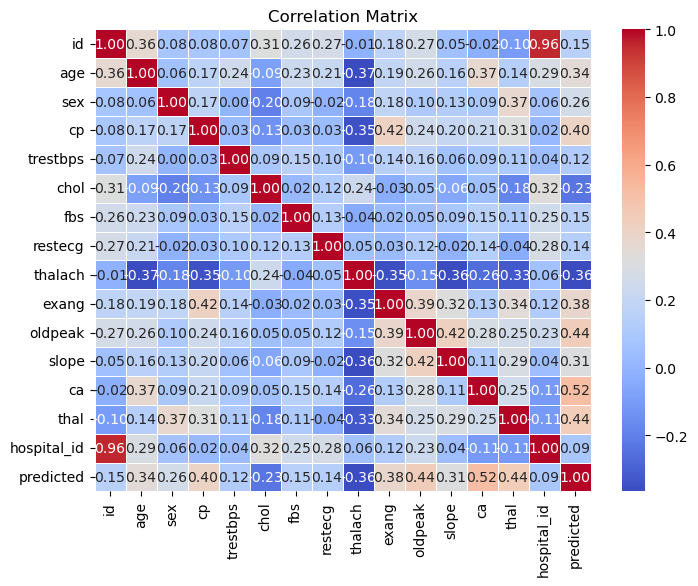

In [37]:
# to look at data correlations: 

correlation_matrix = df_concatenated.corr()
#para visualizar la matriz de correlaciones: 

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix')
plt.show()   

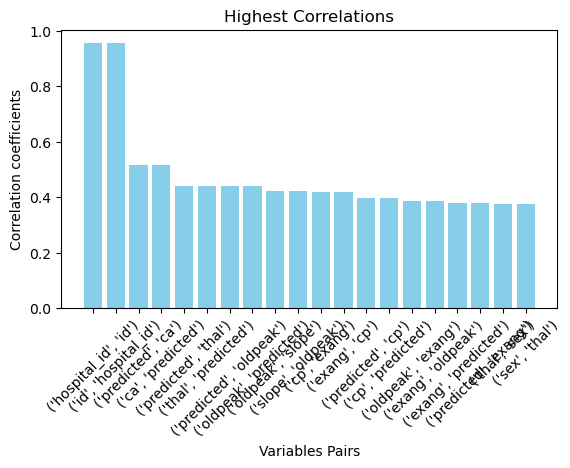

In [41]:
highest_correlations = correlation_matrix.abs().unstack().sort_values(ascending=False) # te coge los valores que tienen mayor correlación entre ellos
highest_correlations = highest_correlations[highest_correlations != 1] # que sea diferente de 1, porque si es 1 será entre clases


plt.bar(range(len(highest_correlations[:20])), highest_correlations[:20], color='skyblue')
plt.xlabel('Variables Pairs')
plt.ylabel('Correlation coefficients')
plt.title('Highest Correlations')
plt.xticks(range(len(highest_correlations[:20])), highest_correlations[:20].index, rotation=45)
plt.subplots_adjust(bottom=0.3)
plt.show()

# Use factors to filter patients 

In [50]:
df_concatenated
df_concatenated_hosp = df_concatenated.columns.get_loc('hospital_id')
print(df_concatenated_hosp)

14


## Filtering by hospital: 

In [74]:
# Tryout
# hospital_ids = [1,2,3,4]
# def filter_hospital(col_index, valor, df):
#     for i in range(df.shape[0]):
#         if df.iloc[i, col_index] != valor:
#             df.drop(i)

In [83]:
df_hosp_H

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hospital_id,predicted
0,1,32,1,1.0,95.0,0.0,<NA>,0.0,127.0,False,0.7,1,<NA>,<NA>,1,1
1,2,34,1,4.0,115.0,0.0,<NA>,NaN,154.0,False,0.2,1,<NA>,<NA>,1,1
2,3,35,1,4.0,NaN,0.0,<NA>,0.0,130.0,True,NaN,<NA>,<NA>,7,1,3
3,4,36,1,4.0,110.0,0.0,<NA>,0.0,125.0,True,1.0,2,<NA>,6,1,1
4,5,38,0,4.0,105.0,0.0,<NA>,0.0,166.0,False,2.8,1,<NA>,<NA>,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,0,4.0,127.0,333.0,True,1.0,154.0,False,0.0,<NA>,<NA>,<NA>,4,1
916,917,62,1,1.0,NaN,139.0,False,1.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0
917,918,55,1,4.0,122.0,223.0,True,1.0,100.0,False,0.0,<NA>,<NA>,6,4,2
918,919,58,1,4.0,NaN,385.0,True,2.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0


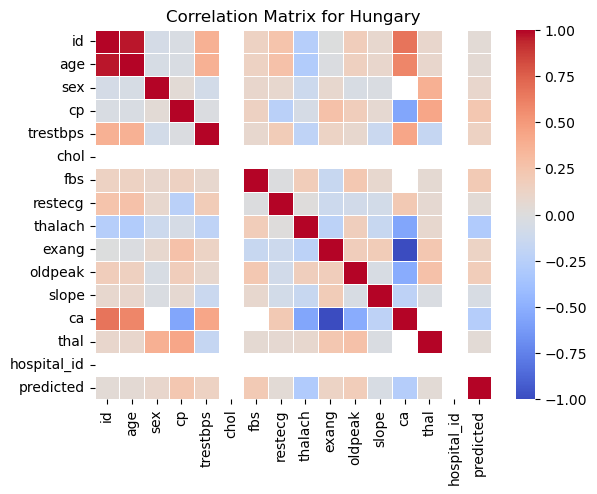

In [115]:
df_hosp_H = df_concatenated.copy()
filas_seleccionadas_H = df_hosp_H[df_hosp_H['hospital_id'] == 1]
correlation_matrix_H = filas_seleccionadas_H.corr()
sns.heatmap(correlation_matrix_H, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Hungary')

plt.show()

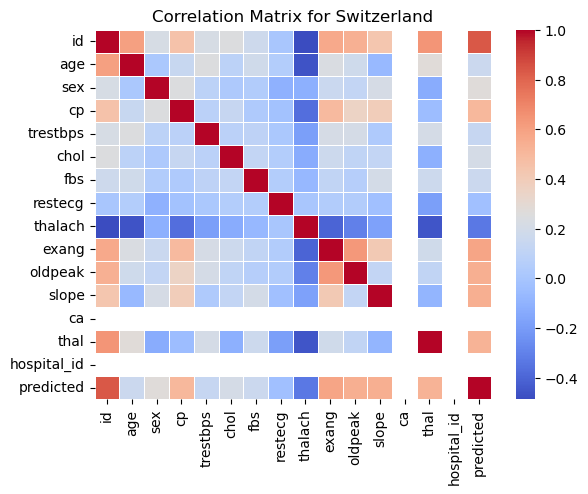

In [113]:
df_hosp_S = df_concatenated.copy()
filas_seleccionadas_S = df_hosp_S[df_hosp_S['hospital_id'] == 2]
correlation_matrix_S = filas_seleccionadas_S.corr()
sns.heatmap(correlation_matrix_S, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Switzerland')

plt.show()

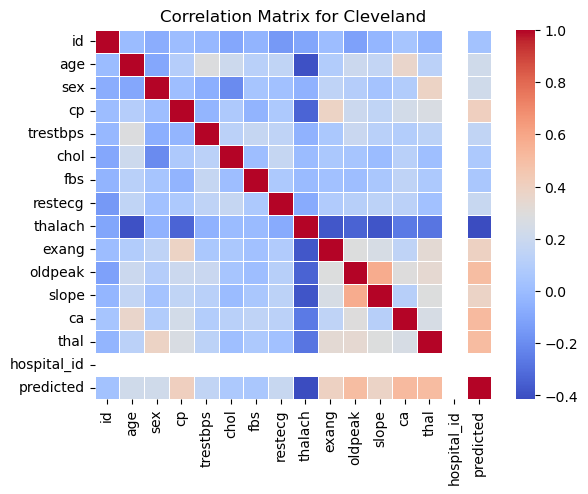

In [114]:
df_hosp_Clev = df_concatenated.copy() 
filas_seleccionadas_Clev = df_hosp_Clev[df_hosp_Clev['hospital_id'] == 3]
correlation_matrix_Clev = filas_seleccionadas_Clev.corr()
sns.heatmap(correlation_matrix_Clev, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Cleveland')

plt.show()

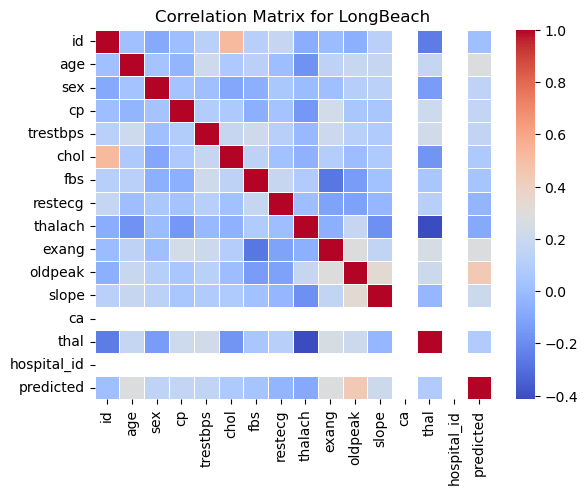

In [116]:
df_hosp_LB = df_concatenated.copy() 
filas_seleccionadas_LB = df_hosp_LB[df_hosp_LB['hospital_id'] == 4]
correlation_matrix_LB = filas_seleccionadas_LB.corr()
sns.heatmap(correlation_matrix_LB, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for LongBeach')

plt.show()

In [99]:
# ahora habría que mirar si en función del hospital la correlación entre los factores es diferente: 
df_concatenated

,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hospital_id,predicted
0,1,32,1,1.0,95.0,0.0,<NA>,0.0,127.0,False,0.7,1,<NA>,<NA>,1,1
1,2,34,1,4.0,115.0,0.0,<NA>,NaN,154.0,False,0.2,1,<NA>,<NA>,1,1
2,3,35,1,4.0,NaN,0.0,<NA>,0.0,130.0,True,NaN,<NA>,<NA>,7,1,3
3,4,36,1,4.0,110.0,0.0,<NA>,0.0,125.0,True,1.0,2,<NA>,6,1,1
4,5,38,0,4.0,105.0,0.0,<NA>,0.0,166.0,False,2.8,1,<NA>,<NA>,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,0,4.0,127.0,333.0,True,1.0,154.0,False,0.0,<NA>,<NA>,<NA>,4,1
916,917,62,1,1.0,NaN,139.0,False,1.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0
917,918,55,1,4.0,122.0,223.0,True,1.0,100.0,False,0.0,<NA>,<NA>,6,4,2
918,919,58,1,4.0,NaN,385.0,True,2.0,NaN,<NA>,NaN,<NA>,<NA>,<NA>,4,0


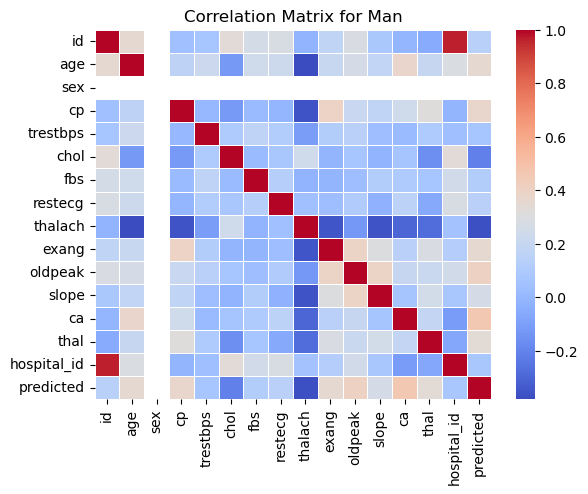

In [111]:
## esto es para ver como afecta el sexo a la correlación de los distintos factores: 

df_Masc = df_concatenated.copy()      
filas_seleccionadas_Masc = df_Masc[df_Masc['sex'] == 1]
correlation_matrix_Masc = filas_seleccionadas_Masc.corr()
sns.heatmap(correlation_matrix_Masc, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Man')

plt.show()

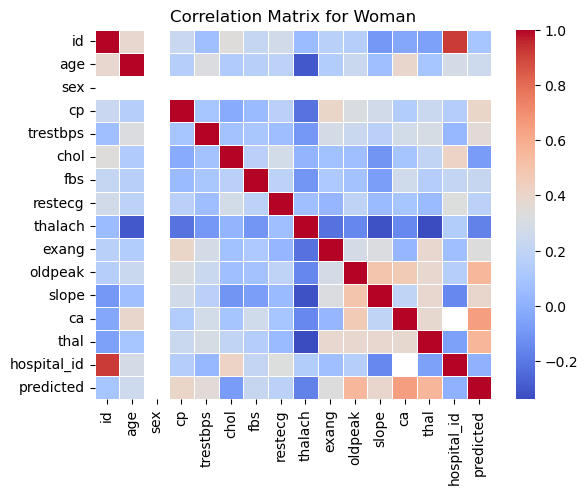

In [112]:
df_Fem  = df_concatenated.copy()
filas_seleccionadas_Fem = df_Fem[df_Fem['sex'] == 0]
correlation_matrix_Fem = filas_seleccionadas_Fem.corr()
sns.heatmap(correlation_matrix_Fem, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Woman')

plt.show()

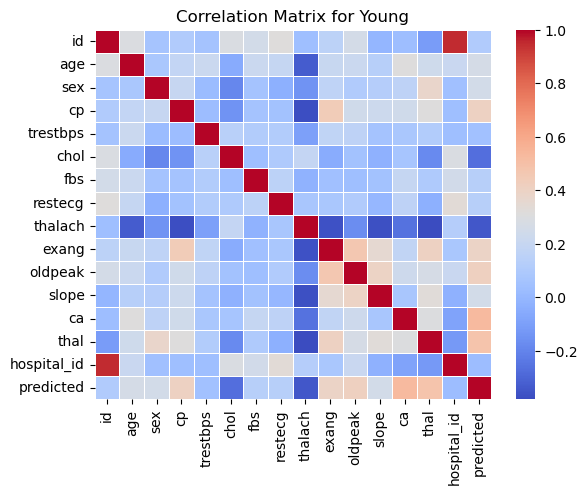

In [108]:
df_Young = df_concatenated.copy()      
filas_seleccionadas_Young = df_Young[df_Young['age'] <= 60]
correlation_matrix_Young = filas_seleccionadas_Young.corr()
sns.heatmap(correlation_matrix_Young, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Young')

plt.show()

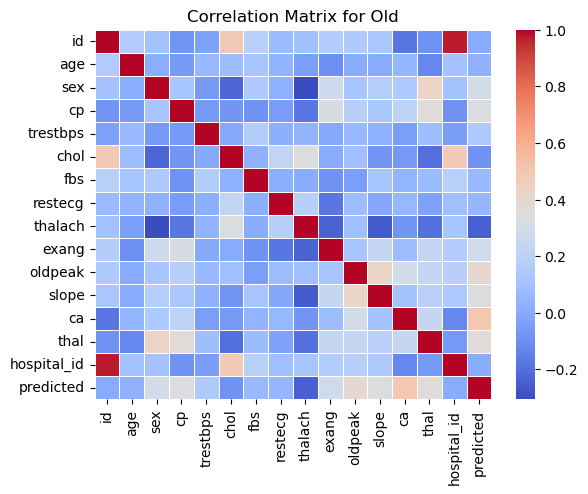

In [110]:
df_Old = df_concatenated.copy()
filas_seleccionadas_Old = df_Old[df_Old['age'] >= 60]
correlation_matrix_Old = filas_seleccionadas_Old.corr()
sns.heatmap(correlation_matrix_Old, annot = False, cmap = 'coolwarm', fmt=".2f", linewidths = 0.5)
plt.title('Correlation Matrix for Old')

plt.show()

PCA analysis for the age case: 

In [134]:
df_concatenated = df_concatenated.dropna() # otherwise PCA can't be done

X = df_concatenated.iloc[:, [col for col in range(len(df_concatenated.columns)) if col != 1]] # select all the factors except age
y = df_concatenated.iloc[:,1] # select age

# Splitting X and y into training and testing sets: 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 20, random_state = 0)

# Preprocessing: 
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Applying PCA function: 
pca = PCA(n_components = 2)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
 
explained_variance = pca.explained_variance_ratio_

# Fitting Logistic Regression To the training set
from sklearn.linear_model import LogisticRegression  
 
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# predict function under LogisticRegression 
y_pred = classifier.predict(X_test)

# making confusion matrix between test set of Y and predicted value:
cm = confusion_matrix(y_test, y_pred)



C:\Users\pms20\AppData\Local\Temp\ipykernel_26144\740818637.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],


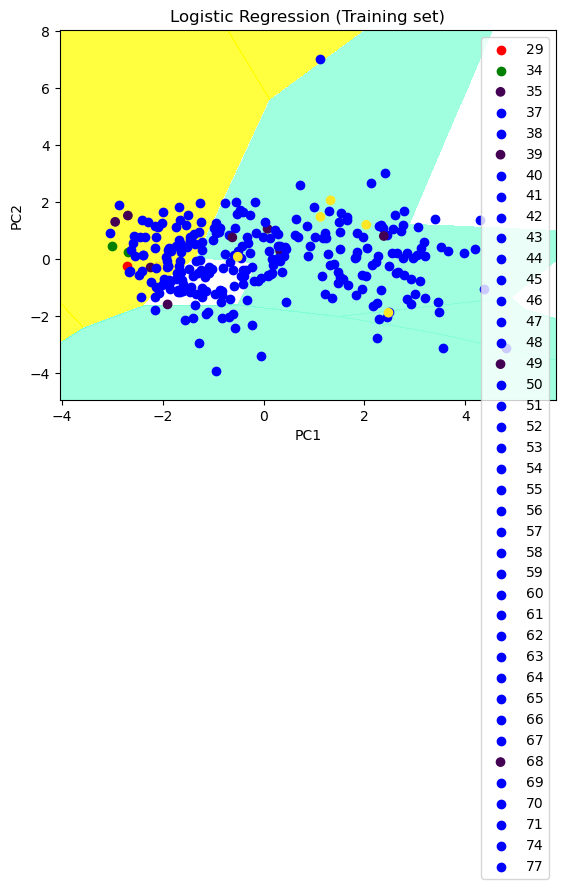

In [135]:
# Predicting the training set
# result through scatter plot 
from matplotlib.colors import ListedColormap
 
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                     stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1,
                     stop = X_set[:, 1].max() + 1, step = 0.01))
 
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(),
             X2.ravel()]).T).reshape(X1.shape), alpha = 0.75,
             cmap = ListedColormap(('yellow', 'white', 'aquamarine')))
 
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
 
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green', 'blue'))(i), label = j)
 
plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1') # for Xlabel
plt.ylabel('PC2') # for Ylabel
plt.legend() # to show legend
 
# show scatter plot
plt.show()